In [35]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Cargar los distintos datos

# Spikes
vix_data = pd.read_excel("output/vix_model_data.xlsx")
vix_data['Year'] = vix_data["Trade Date"].dt.year
spikes = vix_data[vix_data["Spike"] == "Yes"]
spikes = spikes[["Trade Date", "VIX", "Year"]]
# Cargar los datos
model_data = pd.read_excel("output/model_data_spike_5d.xlsx")
model_data['Year'] = model_data["Trade Date"].dt.year
model_data.set_index('Trade Date', inplace=True)

# Datos de 2024 y 2025
data_last_2y = model_data[(model_data.Year == 2025) | (model_data.Year == 2024)]

# Datos de 2025
data_last_y =  model_data[(model_data.Year == 2025)]

# Datos para entrenar al modelo, hasta 2023
model_data = model_data[~((model_data.Year == 2025) | (model_data.Year == 2024))]

# Eliminar columnas innecesarias
if "Futures Curve Skew" in model_data.columns:
    model_data = model_data.drop(columns=["Futures Curve Skew"])
    data_last_2y = data_last_2y.drop(columns=["Futures Curve Skew"])
    data_last_y = data_last_y.drop(columns=["Futures Curve Skew"])
data_last_2y = data_last_2y.drop(columns=["Year"])
data_last_y = data_last_y.drop(columns=["Year"])
model_data = model_data.drop(columns=["Year"])


In [40]:
spikes

,Trade Date,VIX,Year
0,2004-03-26,17.33,2004
1,2004-03-29,16.50,2004
2,2004-03-30,16.28,2004
3,2004-03-31,16.74,2004
4,2004-04-01,16.65,2004
...,...,...,...
5271,2025-03-12,24.23,2025
5272,2025-03-13,24.66,2025
5273,2025-03-14,21.77,2025
5274,2025-03-17,20.51,2025


In [3]:
# Separar features (X) y target (y)
X = model_data.drop(columns=['Spike in 5D'])
y = model_data['Spike in 5D']

# Codificar la variable objetivo (Yes=1, No=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir los datos en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [4]:
# Calcular el balance de clases para ajustar `scale_pos_weight`
pos_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)  # (negatives / positives)

# Configurar el clasificador XGBoost para clasificación binaria
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=pos_weight,  # Manejo del desbalanceo
    use_label_encoder=False
)

# Hiperparámetros para el tuning
param_dist = {
    'n_estimators': [100, 250, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 1, 5],
    'reg_lambda': [1, 10, 100]
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV para búsqueda eficiente de hiperparámetros
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1',  # Mejor métrica para desbalanceo
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Ajustar el modelo con los datos de entrenamiento
random_search.fit(X_train, y_train)

# Resultados del mejor modelo
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor puntuación de validación cruzada:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\alber\OneDrive - CAAN Alternative Asset Management, S.A\Escritorio\vix_data\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:17:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros: {'subsample': 1, 'reg_lambda': 1, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1}
Mejor puntuación de validación cruzada: 0.46990997186672184


In [8]:
best_model = random_search.best_estimator_

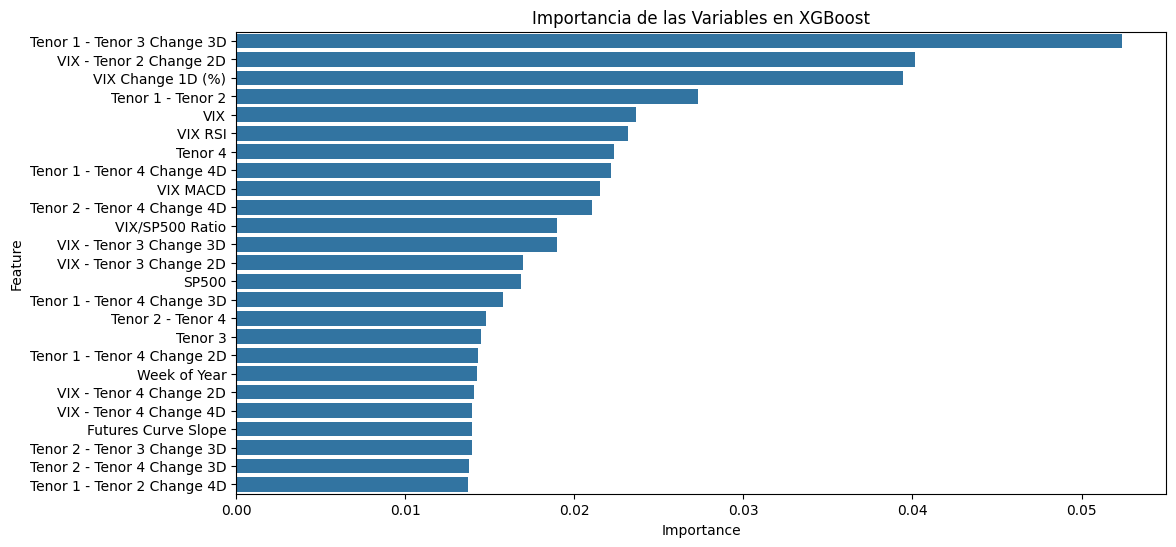

In [11]:
# Obtener importancias de las variables
feature_importance = best_model.feature_importances_

# Crear un DataFrame con los nombres de las variables y su importancia
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Ordenar de mayor a menor
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Gráfico de barras
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(25))  # Top 20
plt.title("Importancia de las Variables en XGBoost")
plt.show()

### PREDICCIONES EN TEST

In [13]:
# Predicciones en el conjunto de prueba

y_pred_encoded = best_model.predict(X_test)

# Decodificar las predicciones
y_pred = label_encoder.inverse_transform(y_pred_encoded)

In [14]:
# Evaluación del modelo con el set de test
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_encoded))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_encoded))

print("\nPrecisión general:")
print(accuracy_score(y_test, y_pred_encoded))


Matriz de confusión:
[[572 126]
 [ 85  87]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       698
           1       0.41      0.51      0.45       172

    accuracy                           0.76       870
   macro avg       0.64      0.66      0.65       870
weighted avg       0.78      0.76      0.77       870


Precisión general:
0.7574712643678161


### PREDICCIONES AÑO 2025

In [20]:
# Separar features (X) y target (y)
X = data_last_y.drop(columns=['Spike in 5D'])
y = data_last_y['Spike in 5D']

# Codificar la variable objetivo (Yes=1, No=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Generar predicciones sobre el conjunto de prueba
y_pred_encoded = best_model.predict(X)

# Decodificar las predicciones
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Crear un DataFrame con las fechas de las predicciones (solo las de la prueba)
predicted_dates = X.index

In [30]:
spikes[spikes['Trade Date'].isin(spike_dates)]

,Trade Date,VIX,Spike
5224,2025-01-02,17.93,Yes
5225,2025-01-03,16.13,No
5226,2025-01-06,16.04,No
5227,2025-01-07,17.82,No
5228,2025-01-08,17.70,No
5230,2025-01-10,19.54,Yes
5231,2025-01-13,19.19,No
5232,2025-01-14,18.71,No
5234,2025-01-16,16.60,No
5236,2025-01-21,15.06,No


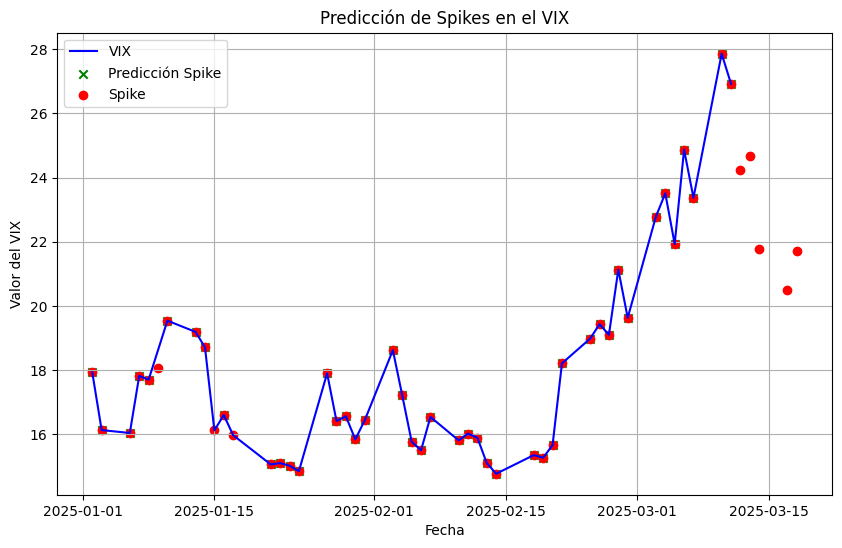

In [34]:
# Identificar los días donde el modelo predice un spike (predicción = 1)
spike_dates = predicted_dates[y_pred_encoded == 1]

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar el VIX
plt.plot(data_last_y.index, data_last_y['VIX'], label='VIX', color='blue')

# Marcar los puntos verdes donde el modelo predice un spike
plt.scatter(spike_dates, data_last_y.loc[spike_dates, 'VIX'], color='green', label='Predicción Spike', marker='x')

spikes = spikes[spikes['Year'] == 2025]
# Marcar los puntos rojos donde hay un spike
plt.scatter(spikes["Trade Date"],spikes["VIX"], color='red', label='Spike', marker='o')

# Personalización del gráfico
plt.title('Predicción de Spikes en el VIX')
plt.xlabel('Fecha')
plt.ylabel('Valor del VIX')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

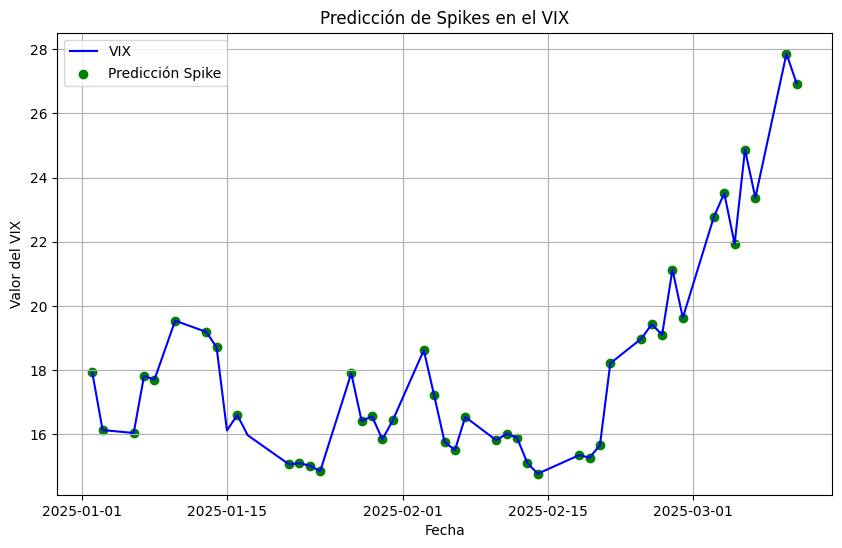

In [53]:
# Evaluación del modelo con el set de test
print("\nMatriz de confusión:")
print(confusion_matrix(y, y_pred_encoded))

print("\nReporte de clasificación:")
print(classification_report(y, y_pred_encoded))

print("\nPrecisión general:")
print(accuracy_score(y, y_pred_encoded))


Matriz de confusión:


TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=['No' 'Yes'] and y_pred=[0 1]. Make sure that the predictions provided by the classifier coincides with the true labels.

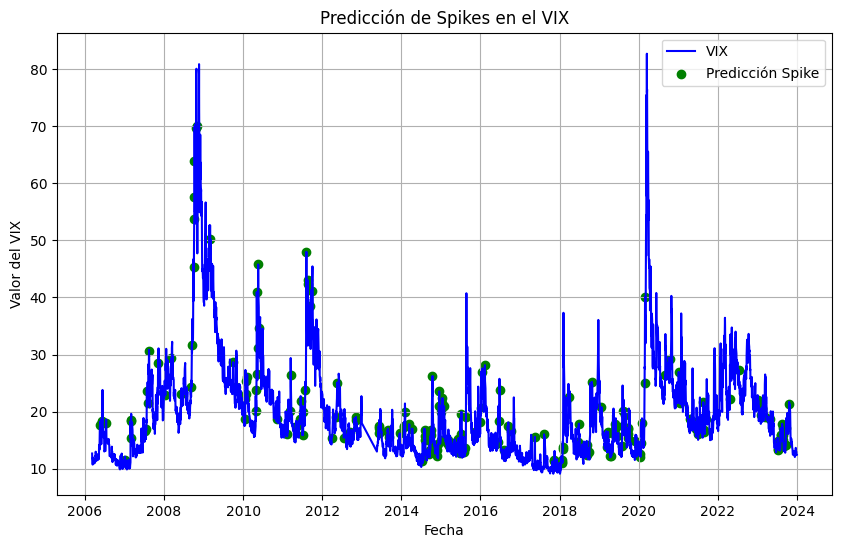

In [24]:
# Generar predicciones sobre el conjunto de prueba
y_pred_encoded = best_model.predict(X_test)

# Decodificar las predicciones
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Crear un DataFrame con las fechas de las predicciones (solo las de la prueba)
predicted_dates = X_test.index

# Identificar los días donde el modelo predice un spike (predicción = 1)
spike_dates = predicted_dates[y_pred_encoded == 1]

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar el VIX
plt.plot(model_data.index, model_data['VIX'], label='VIX', color='blue')

# Marcar los puntos verdes donde el modelo predice un spike
plt.scatter(spike_dates, model_data.loc[spike_dates, 'VIX'], color='green', label='Predicción Spike', marker='o')

# Personalización del gráfico
plt.title('Predicción de Spikes en el VIX')
plt.xlabel('Fecha')
plt.ylabel('Valor del VIX')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()